# MNIST uncertainty classification

Credits to Sebastian Seurig, TU Dresden

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 1024
num_classes = 10
epochs = 20
input_shape = (28, 28, 1)

## load data

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.
/home/debacwa/miniconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/debacwa/miniconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/debacwa/miniconda3/envs/dl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/debacwa/miniconda3/e

In [4]:
x_train = x_train.astype('float32')
x_train /= 255.
x_train = x_train[..., np.newaxis]

x_test  = x_test.astype('float32')
x_test  /= 255.
x_test  = x_test[..., np.newaxis]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
from keras.utils import to_categorical 
y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print(y_train.shape[0], 'train samples')
print(y_test.shape[0], 'test samples')


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)
60000 train samples
10000 test samples


# create model

In [5]:
from keras import backend as K

from keras.activations import softmax
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
T = 10
def kendall_loss(y_true, y_pred):
    num_classes = K.int_shape(y_pred)[-1] // 2
    mu    = y_pred[...,:num_classes]
    sigma = y_pred[...,num_classes:] ####### NOT :num_classes
    
    if T == 0: # if T=0, no sampling is done, revert to conventional cross entropy (ignoring sigma)
        # pull through softmax to get probabilities
        phat = softmax(mu, axis=-1)
        # calculate cross entropy over the sampled predictions
        loss = categorical_crossentropy(y_true, phat)
        return loss
      
    else: # if T>0, perform Monte Carlo sampling
        loss = K.zeros_like(mu[...,0])
        for t in range(T):
            # draw random sample with from standard normal distribution
            eps = K.truncated_normal(shape=K.shape(mu), mean=0.0, stddev=1.0) 
            # add sigma-dependent noise to mean predictions 
            xhat = mu + sigma*eps
            # pull through softmax to get probabilities
            phat = softmax(xhat, axis=-1)
            # calculate cross entropy over the sampled predictions
            loss_sample = categorical_crossentropy(y_true, phat)
            loss += loss_sample
        return loss / T
      
def accuracy(y_true, y_pred):
    num_classes = K.int_shape(y_pred)[-1] // 2
    return categorical_accuracy(y_true, y_pred[...,:num_classes])

In [6]:
def get_model(input_shape, num_classes):
    from keras import layers, models

    i = layers.Input(shape=input_shape)

    n_filters = 32
    x = layers.Conv2D(n_filters, kernel_size=(3, 3), activation='relu')(i)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(n_filters*2, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(n_filters*4, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)                 
    x = layers.Dropout(0.5)(x, training=True)

    logits = layers.Dense(num_classes, name='logits')(x)
    mu     = layers.Activation('softmax', name='mean')(logits)
    sigma  = layers.Dense(num_classes, activation='softplus', name='sigma')(x)

    o = layers.Concatenate(axis=-1, name='output')([logits, sigma]) # (batch_size, num_classes*2)

    return models.Model(inputs=i, outputs=[o, mu, sigma])

In [7]:
model = get_model(input_shape=input_shape, num_classes=num_classes)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 13, 13, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 11, 11, 64)   18496       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

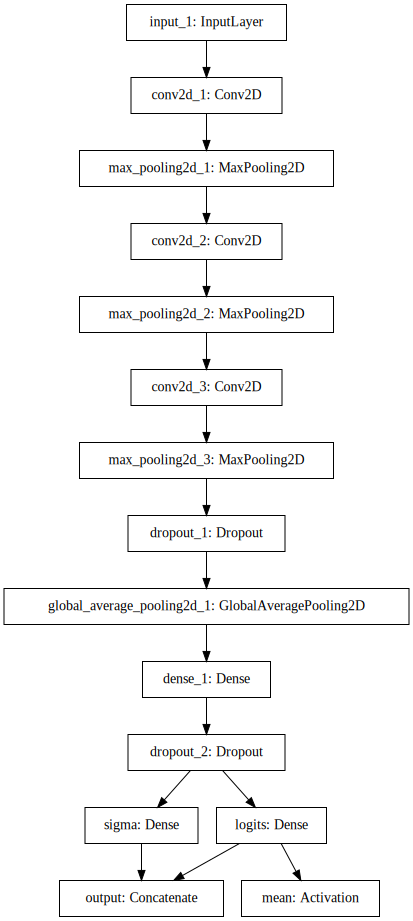

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, rankdir='TB').create(prog='dot', format='svg'))

# train

In [10]:
from keras import optimizers
model.compile(loss=[kendall_loss, None, None],
              optimizer=optimizers.Adam(lr=0.001),
              metrics=[accuracy])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          verbose=1)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 106us/step - loss: 1.2862 - output_loss: 1.2862 - output_accuracy: 0.5764 - val_loss: 0.3702 - val_output_loss: 0.3702 - val_output_accuracy: 0.8935
Epoch 2/20
60000/60000 [==============================] - 1s 22us/step - loss: 0.3425 - output_loss: 0.3425 - output_accuracy: 0.8979 - val_loss: 0.1857 - val_output_loss: 0.1857 - val_output_accuracy: 0.9467
Epoch 3/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.2212 - output_loss: 0.2212 - output_accuracy: 0.9359 - val_loss: 0.1395 - val_output_loss: 0.1395 - val_output_accuracy: 0.9600
Epoch 4/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.1727 - output_loss: 0.1727 - output_accuracy: 0.9490 - val_loss: 0.1083 - val_output_loss: 0.1083 - val_output_accuracy: 0.9683
Epoch 5/20
60000/

# predict

In [11]:
val_loss, _, val_acc = model.evaluate(x=x_test, y=y_test)
print(f'validation loss = {val_loss:.3f}, validation accuracy = {val_acc:.3f}')

10000/10000 [==============================] - 2s 155us/step
validation loss = 0.051, validation accuracy = 0.986


In [12]:
def predict(model, x, T=10):
    '''Perform T forward passes to estimate class probabilities and their uncertainties'''
    
    means, sigmas = [], []
    for _ in range(T):
        _, mean, sigma = model.predict(x_test)
        means.append(mean)
        sigmas.append(sigma)
    means  = np.array(means)
    sigmas = np.array(sigmas)
    
    probabilities = np.mean(means, axis=0)
    predictions   = np.argmax(probabilities, axis=-1)
    
    aleatoric   = np.mean(sigmas, axis=0)
    epistemic   = np.mean(means**2, axis=0) - np.mean(means, axis=0)**2
    predictive  = np.mean(means**2, axis=0) - np.mean(means, axis=0)**2 + np.mean(sigmas**2, axis=0)

    return {'predictions':predictions, 
            'probabilities':probabilities, 
            'aleatoric':aleatoric, 
            'epistemic':epistemic, 
            'predictive':predictive}
        

In [13]:
def get_false_predictions(data, prediction_output, y_true):

    predictions = prediction_output['predictions']
    y_true_int = np.argmax(y_true, axis=-1)

    # get indices of false predictions
    indices_false = np.where( np.not_equal(predictions, y_true_int) )
    
    data          = data[indices_false]
    y_true_int    = y_true_int[indices_false]

    predictions   = prediction_output['predictions'][indices_false]
    probabilities = prediction_output['probabilities'][indices_false]
    aleatoric     = prediction_output['aleatoric'][indices_false]
    epistemic     = prediction_output['epistemic'][indices_false]
    predictive    = prediction_output['predictive'][indices_false]
    

    return data, y_true_int, {'predictions':predictions, 
                              'probabilities':probabilities, 
                              'aleatoric':aleatoric, 
                              'epistemic':epistemic, 
                              'predictive':predictive} 

In [14]:
def plot(data, prediction_output, y_true, sample):

    predictions, probabilities, aleatoric, epistemic, predictive = prediction_output
    
    fig, ax = plt.subplots(1,2, figsize = (10,3))

    ax[0].imshow(np.squeeze(data[sample]), cmap='gray_r', interpolation='bicubic')
    true = y_true[sample] if y_true.ndim == 1 else np.argmax(y_true, axis=-1)[sample]
    predicted = prediction_output['predictions'][sample]
    ax[0].set_title(f'True: {true}, Predicted: {predicted}')
    ax[0].axis('off')
    

    x = list(range(num_classes))
    height = prediction_output['probabilities'][sample]
    err = prediction_output['predictive'][sample]
    ax[1].bar(x, height, yerr=err, capsize=5.0)
    #ax[1].set_xlim([0, num_classes])
    ax[1].set_ylim(bottom=0)
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(x)
    ax[1].set_ylabel('Probability and uncertainty')
    _ = ax[1].set_xlabel('Class label')

In [15]:
# get predictions, probabilities and uncertainties by T forward passes
prediction_output = predict(model, x_test, T=10)


### Random samples in validation set

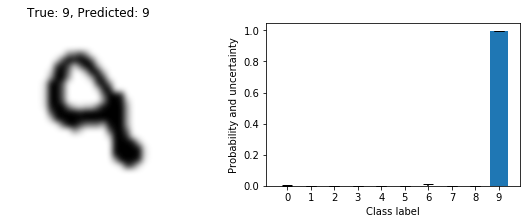

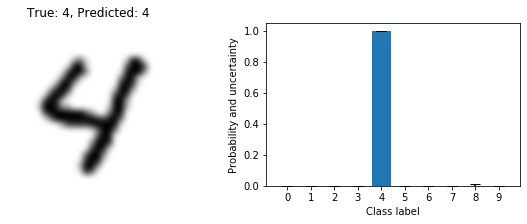

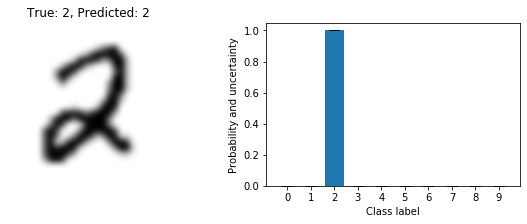

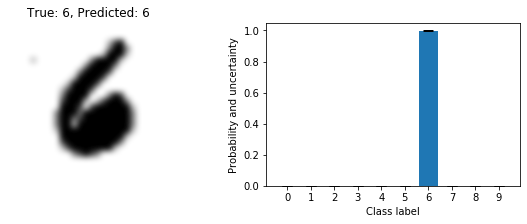

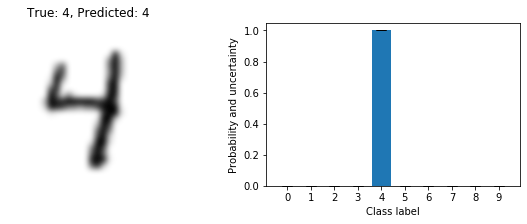

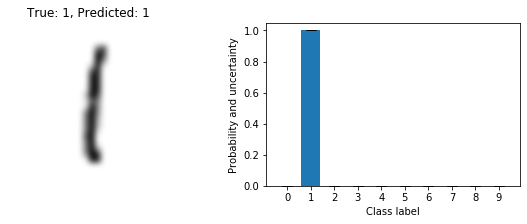

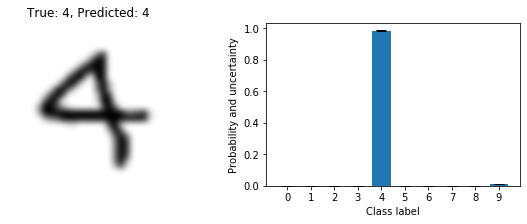

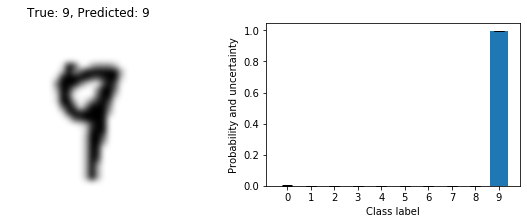

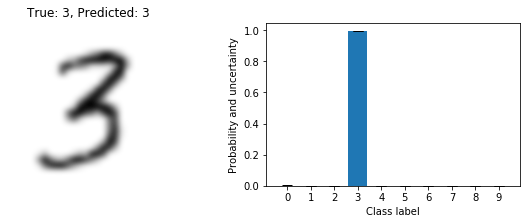

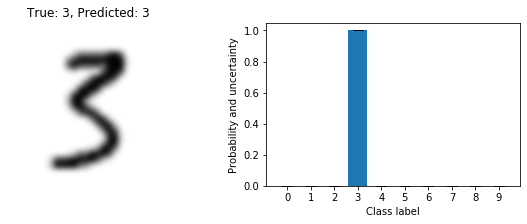

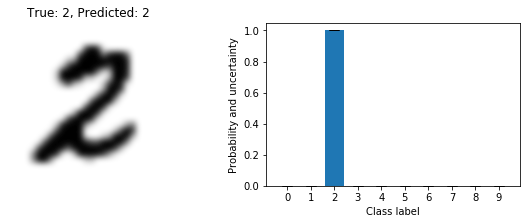

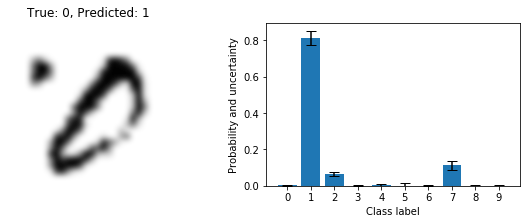

In [16]:
# plot n samples
n = 12
for i in range(n):
    sample = np.random.randint(len(x_test)) 
    plot(x_test, prediction_output, y_test, sample=sample)
    plt.show()
    plt.close()

### Falsely classified validation samples

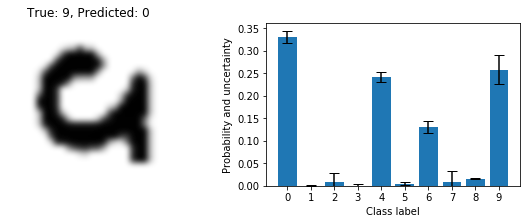

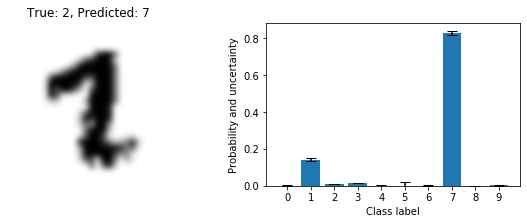

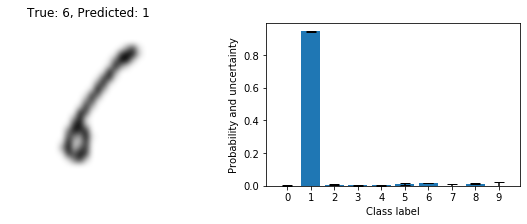

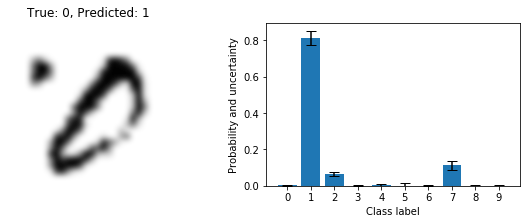

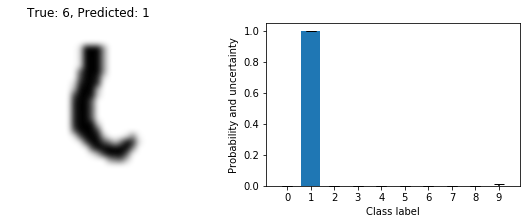

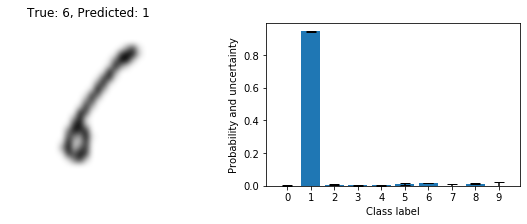

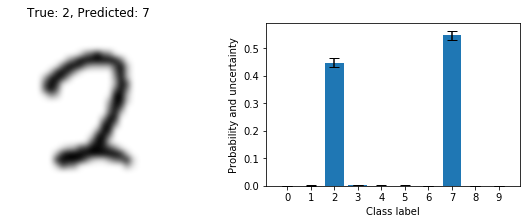

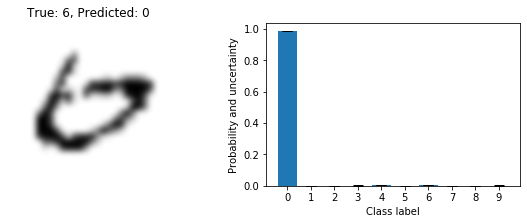

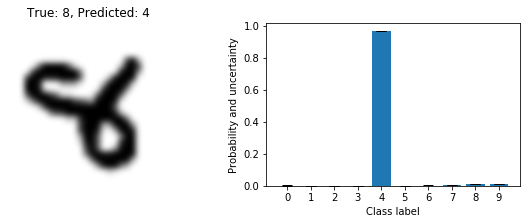

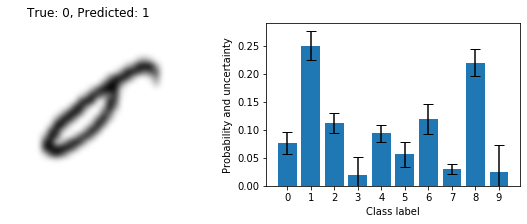

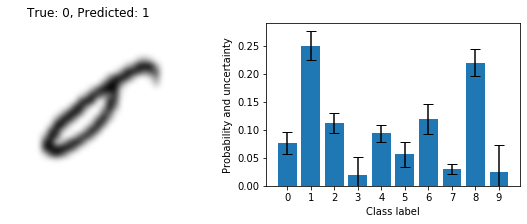

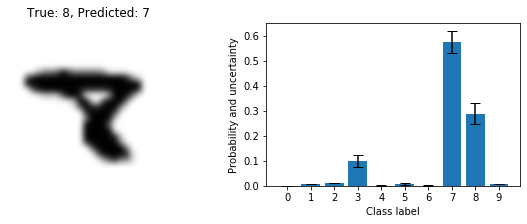

In [17]:
# extract the false classified samples
x_test_false, y_true_false, prediction_output_false = get_false_predictions(x_test, prediction_output, y_test)

# plot n samples
n = 12
for i in range(n):
    sample = np.random.randint(len(x_test_false)) 
    plot(x_test_false, prediction_output_false, y_true_false, sample=sample)
    plt.show()
    plt.close()

## Error versus probabilities

Text(0, 0.5, 'epistemic uncertainty')

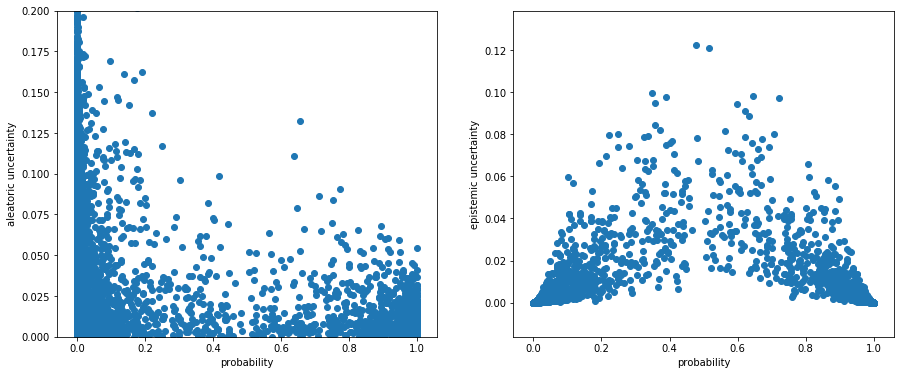

In [18]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].scatter(prediction_output['probabilities'].flatten(), prediction_output['aleatoric'].flatten())
ax[0].set_xlabel('probability')
ax[0].set_ylabel('aleatoric uncertainty')
#ax[0].set_xlim(left=0.0)
ax[0].set_ylim(0,0.2)

ax[1].scatter(prediction_output['probabilities'].flatten(), prediction_output['epistemic'].flatten())
ax[1].set_xlabel('probability')
ax[1].set_ylabel('epistemic uncertainty')
